<a href="https://colab.research.google.com/github/hamzzihyun/competition/blob/main/%ED%8F%AC%EB%94%94%EB%B8%94%EB%A1%9D%EA%B5%AC%EC%A1%B0%EC%B6%94%EC%B6%9CAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/DACON/4D_block/open.zip') as z:
  z.extractall()

## Import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')

print('CUDA 사용 가능 여부 :', USE_CUDA)
print('현재 사용 device :', device)
print('CUDA Index :', torch.cuda.current_device())
print('GPU 이름 :', torch.cuda.get_device_name())
print('GPU 개수 :', torch.cuda.device_count())

CUDA 사용 가능 여부 : True
현재 사용 device : cuda:0
CUDA Index : 0
GPU 이름 : Tesla T4
GPU 개수 : 1


## Hyperparameter Setting

In [ ]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':8, #128
    'SEED':41
}

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [ ]:
df = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [ ]:
print(df.columns)
print(df.shape)
df.head()

Index(['id', 'img_path', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype='object')
(32994, 12)


,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,./train/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0
1,TRAIN_00001,./train/TRAIN_00001.jpg,1,0,0,0,0,0,0,0,0,0
2,TRAIN_00002,./train/TRAIN_00002.jpg,1,0,0,0,0,0,0,0,0,0
3,TRAIN_00003,./train/TRAIN_00003.jpg,1,0,0,0,0,0,0,0,0,0
4,TRAIN_00004,./train/TRAIN_00004.jpg,1,0,0,0,0,0,0,0,0,0


In [ ]:
import glob
image_dir_train = '/content/train'
image_dir_test = '/content/test'

len(glob.glob('/content/train/*.jpg')), len(glob.glob('/content/test/*.jpg'))

(32994, 1460)

In [ ]:
train_images = sorted(glob.glob(image_dir_train+'/*.jpg'))
test_images = sorted(glob.glob(image_dir_test+'/*.jpg'))

print(train_images[0])
print(train_images[-1])
print(test_images[0])
print(test_images[-1])

/content/train/TRAIN_00000.jpg
/content/train/TRAIN_32993.jpg
/content/test/TEST_00000.jpg
/content/test/TEST_01459.jpg


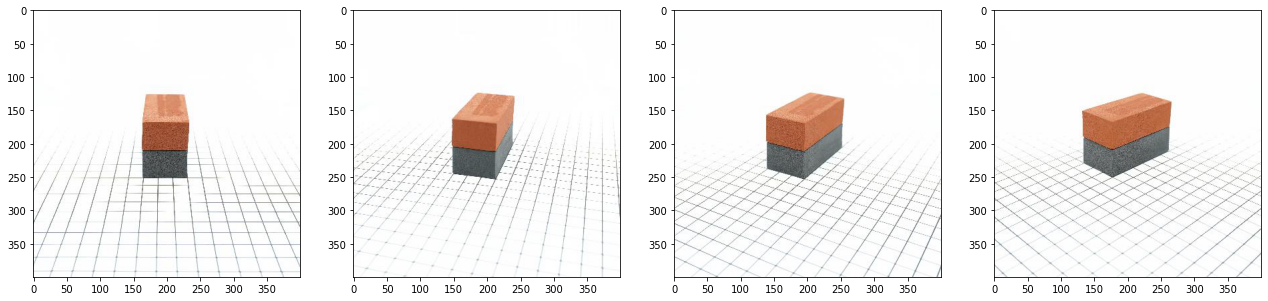

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows = 1
ncols = 4
figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (22, 6))

for i,images in enumerate(train_images[:ncols]):
    img = mpimg.imread(images)
    axes[i].imshow(img)

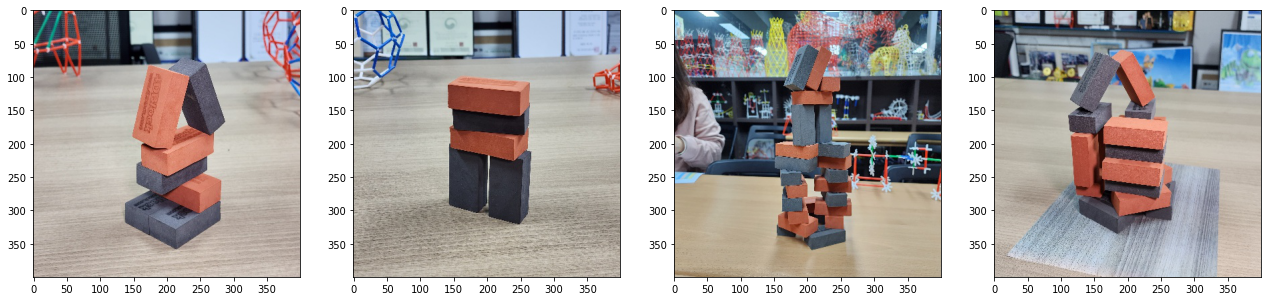

In [ ]:
nrows = 1
ncols = 4
figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (22, 6))

for i,images in enumerate(test_images[:ncols]):
    img = mpimg.imread(images)
    axes[i].imshow(img)

In [ ]:
# 라벨별 이미지 추출

      A  B  C  D  E  F  G  H  I  J
5411  1  0  0  0  1  1  1  0  0  0


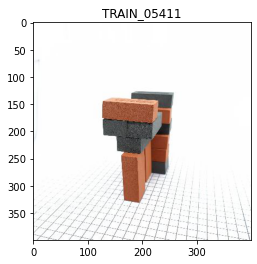

      A  B  C  D  E  F  G  H  I  J
9919  1  0  1  1  0  0  0  0  1  1


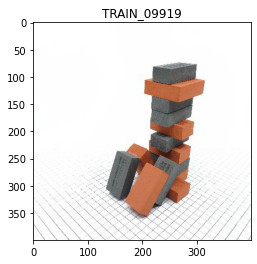

       A  B  C  D  E  F  G  H  I  J
24451  0  0  0  0  0  0  1  0  1  0


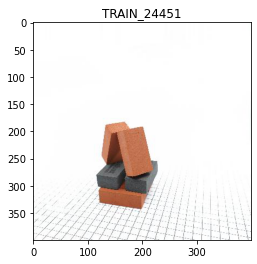

     A  B  C  D  E  F  G  H  I  J
778  0  0  1  0  0  0  0  1  0  0


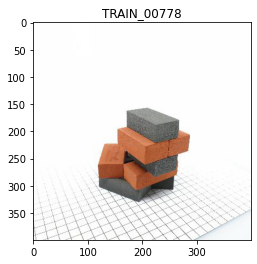

       A  B  C  D  E  F  G  H  I  J
13402  0  0  1  1  0  0  0  1  1  1


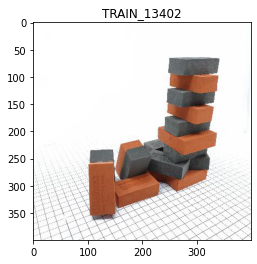

In [ ]:
# 랜덤 이미지 추출
from PIL import Image

img_path = glob.glob('/content/train/*.jpg')

for i in range(5):
  idx = np.random.randint(0, len(img_path))
  image_name = img_path[idx]
  image = Image.open(image_name)
  print(df[df['id'] == image_name[-15:-4]].iloc[:,2:])

  plt.title(image_name[-15:-4])
  plt.imshow(image)
  plt.show()

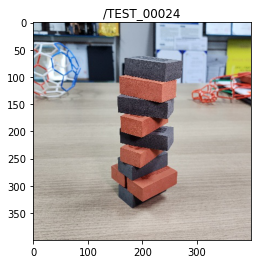

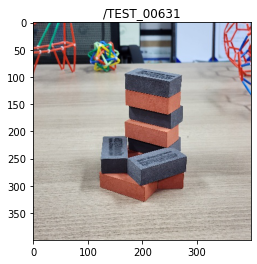

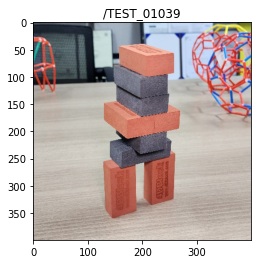

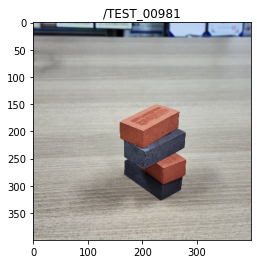

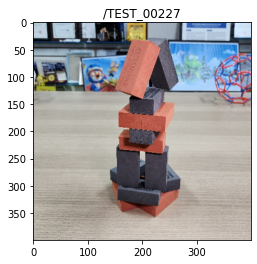

In [ ]:
test_img_path = glob.glob('/content/test/*.jpg')

for i in range(5):
  idx = np.random.randint(0, len(test_img_path))
  image_name = test_img_path[idx]
  image = Image.open(image_name)

  plt.title(image_name[-15:-4])
  plt.imshow(image)
  plt.show()

### 이미지 합성

In [ ]:
!gdown http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar

Downloading...
From: http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar
To: /content/indoorCVPR_09.tar
100% 2.59G/2.59G [02:11<00:00, 19.8MB/s]


In [ ]:
!tar -xvf '/content/indoorCVPR_09.tar'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Images/mall/cover_home3.jpg
Images/mall/CP67791.jpg
Images/mall/crocker_galleria_735089.jpg
Images/mall/mall1.jpg
Images/mall/d8.jpg
Images/mall/deira_city_centre_dubai_08.jpg
Images/mall/dungarv_new_mall.jpg
Images/mall/latham_circle_mall_16.jpg
Images/mall/eastridg1.jpg
Images/mall/IMG_6449.jpg
Images/mall/main_boutique_b.jpg
Images/mall/easyfranchise_centre_commercial_1.jpg
Images/mall/ins42.jpg
Images/mall/mall14.jpg
Images/mall/eaton_centre_2001_03.jpg
Images/mall/ins43.jpg
Images/mall/mall17.jpg
Images/mall/full_shopping_Central_1.jpg
Images/mall/galleria.jpg
Images/mall/galleria1.jpg
Images/mall/galleria2.jpg
Images/mall/Galleria_003.jpg
Images/mall/laurel_mall_06.jpg
Images/mall/Galleria_1.jpg
Images/mall/galleria_san_federico_nr_109_2_n1.jpg
Images/mall/ins23.jpg
Images/mall/ins44.jpg
Images/mall/mall18.jpg
Images/mall/galleria_vittorio_emanuele_ii_milan_mlgalar.jpg
Images/mall/ins45.jpg
Images/mall/mall19.jpg
Images/mall/GUM_Department_Stor

In [ ]:
# train 이미지 mask 추출 후 저장
from tqdm import tqdm
import re

img_path = glob.glob('/content/train/*.jpg')
os.mkdir('/content/masks_')

for i in tqdm(img_path):
  img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
  kernel = np.ones((5, 5),np.uint8)
  mask = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  mask[mask > 240] = 0

  new_path = re.sub('train', 'masks_', i)
  cv2.imwrite(new_path, mask)

100%|██████████| 32994/32994 [01:11<00:00, 459.20it/s]


In [ ]:
dst_imgs = glob.glob('/content/Images/children_room/*.jpg')

In [ ]:
print(len(dst_imgs))
print(dst_imgs)

112
['/content/Images/children_room/web_playroom_70_.jpg', '/content/Images/children_room/AT_01_3B_5486_10_l.jpg', '/content/Images/children_room/VA_04_02_6000_08_l.jpg', '/content/Images/children_room/AT_04_04_2000_78_l.jpg', '/content/Images/children_room/083008_saturday_24__3_.jpg', '/content/Images/children_room/dsc_0090_16_.jpg', '/content/Images/children_room/img_9978_26_.jpg', '/content/Images/children_room/playroom_july_68_.jpg', '/content/Images/children_room/as_playroom_40_.jpg', '/content/Images/children_room/AT_99_1_7838_12A_l.jpg', '/content/Images/children_room/playroom1_53_.jpg', '/content/Images/children_room/ft_playroom01_l_43_.jpg', '/content/Images/children_room/playroom6_31_.jpg', '/content/Images/children_room/reading_circle_time_37_.jpg', '/content/Images/children_room/imgp0662_20_.jpg', '/content/Images/children_room/kids2_46_.jpg', '/content/Images/children_room/VA_03_00_0003_42_l.jpg', '/content/Images/children_room/western_playroom_71_.jpg', '/content/Images/c

In [ ]:
import re
df['mask_imgs'] = df['img_path'].apply(lambda x: re.sub('train', 'masks_', x))

In [ ]:
df = df[['id', 'img_path', 'mask_imgs', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']]
df.head()

,id,img_path,mask_imgs,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,./train/TRAIN_00000.jpg,./masks_/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0
1,TRAIN_00001,./train/TRAIN_00001.jpg,./masks_/TRAIN_00001.jpg,1,0,0,0,0,0,0,0,0,0
2,TRAIN_00002,./train/TRAIN_00002.jpg,./masks_/TRAIN_00002.jpg,1,0,0,0,0,0,0,0,0,0
3,TRAIN_00003,./train/TRAIN_00003.jpg,./masks_/TRAIN_00003.jpg,1,0,0,0,0,0,0,0,0,0
4,TRAIN_00004,./train/TRAIN_00004.jpg,./masks_/TRAIN_00004.jpg,1,0,0,0,0,0,0,0,0,0


## Train / Validation Split

In [ ]:
df = df.sample(frac=1)
train_len = int(len(df) * 0.8)

In [ ]:
train = df[:train_len]
val = df[train_len:]

In [ ]:
print(train.shape)
print(val.shape)

(26395, 13)
(6599, 13)


## Data Preprocessing

In [ ]:
def get_labels(df):
    return df.iloc[:,3:].values

In [ ]:
train_labels = get_labels(train)
val_labels = get_labels(val)

## CustomDataset

In [ ]:
class CustomDataset1(Dataset):
    def __init__(self, img_path_list, label_list, mask_imgs, dst_imgs, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.mask_imgs = mask_imgs
        self.dst_imgs = dst_imgs
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)

        mask_path = self.mask_imgs[index]
        mask1 = cv2.imread(mask_path)

        dst_path = np.random.choice(self.dst_imgs, replace=True)
        dst1 = cv2.imread(dst_path)
        dst1 = cv2.resize(dst1, (400,400))

        new_img = cv2.copyTo(image, mask1, dst1)
        
        if self.transforms is not None:
            new_img = self.transforms(image=new_img)['image']

        if self.label_list is not None:
            label = torch.FloatTensor(self.label_list[index])
            return new_img, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
class CustomDataset2(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = torch.FloatTensor(self.label_list[index])
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
import torchvision.transforms.functional

In [ ]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=15, 
                                               border_mode=cv2.BORDER_REPLICATE),
                            A.augmentations.dropout.cutout.Cutout(num_holes=8, max_h_size=20, max_w_size=20, fill_value=0),
                            A.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            ToTensorV2()
                            ])

In [ ]:
train_dataset = CustomDataset1(train['img_path'].values, train_labels, train['mask_imgs'].values, dst_imgs, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset1(val['img_path'].values, val_labels, train['mask_imgs'].values, dst_imgs, test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

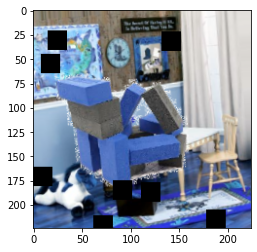

In [ ]:
new_img, _ = train_dataset[0]
plt.imshow(new_img.numpy().transpose(1,2,0))

## Model Define

In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c6876f84654788857dc89d4508e856a305cc0ad4c99f032c8055f5382c480569
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

class SwishImplementation(torch.autograd.Function):
  def forward(ctx, i):
    result = i * torch.sigmoid(i)
    ctx.save_for_backward(i)
    return result

  def backward(ctx, grad_output):
    i = ctx.saved_tensors[0]
    sigmoid_i = torch.sigmoid(i)
    return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class MultiLabelEfficientnet(nn.Module):
    def __init__(self):
        super(MultiLabelEfficientnet, self).__init__()
        self._swish = MemoryEfficientSwish()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b7')
        self.drop = nn.Dropout(p=0.2)
        self.FC = nn.Linear(1000, 10)

    def forward(self, x):
      x = self._swish(self.efficientnet(x))
      x = self.drop(x)
      x = torch.sigmoid(self.FC(x))
      return x

## Train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    
    best_val_acc = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_acc = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val ACC : [{_val_acc:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_acc)
            
        if best_val_acc < _val_acc:
            best_val_acc = _val_acc
            best_model = model
    
    return best_model

In [ ]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    val_acc = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels)
            
            probs  = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = probs > 0.5
            batch_acc = (labels == preds).mean()
            
            val_acc.append(batch_acc)
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_acc = np.mean(val_acc)
    
    return _val_loss, _val_acc

## Run!!

In [ ]:
import gc
model = MultiLabelEfficientnet()
model.eval()

torch.cuda.empty_cache()
gc.collect()

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = CFG["LEARNING_RATE"])
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.85)
criterion = torch.nn.BCELoss()

infer_model = train(model, optimizer, train_loader, val_loader, lr_scheduler, device)

Loaded pretrained weights for efficientnet-b7


100%|██████████| 825/825 [02:35<00:00,  5.30it/s]


Epoch [1], Train Loss : [0.30877] Val Loss : [0.50447] Val ACC : [0.80898]


100%|██████████| 825/825 [02:35<00:00,  5.32it/s]


Epoch [2], Train Loss : [0.14442] Val Loss : [0.56595] Val ACC : [0.82500]


100%|██████████| 825/825 [02:35<00:00,  5.31it/s]


Epoch [3], Train Loss : [0.10972] Val Loss : [0.51565] Val ACC : [0.82576]


100%|██████████| 825/825 [02:36<00:00,  5.29it/s]


Epoch [4], Train Loss : [0.09056] Val Loss : [0.55106] Val ACC : [0.83516]


100%|██████████| 825/825 [02:38<00:00,  5.20it/s]

Epoch [5], Train Loss : [0.08121] Val Loss : [0.54300] Val ACC : [0.84048]


## Inference

In [ ]:
test_dataset = CustomDataset2(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            probs = model(imgs)

            probs  = probs.cpu().detach().numpy()
            preds = probs > 0.5
            preds = preds.astype(int)
            predictions += preds.tolist()
    return predictions

In [ ]:
preds = inference(model, test_loader, device)

100%|██████████| 183/183 [00:24<00:00,  7.38it/s]


## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit.iloc[:,1:] = preds
submit.head()

,id,A,B,C,D,E,F,G,H,I,J
0,TEST_00000,1,1,0,0,0,0,1,0,1,0
1,TEST_00001,1,1,0,0,0,1,0,0,0,0
2,TEST_00002,0,1,0,0,1,1,0,0,0,1
3,TEST_00003,1,1,0,0,0,1,0,1,0,0
4,TEST_00004,0,1,0,0,1,0,0,0,0,0


In [ ]:
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/포디블록(6)_submit.csv', index=False)